In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install tensorflow

In [2]:
main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
import os

In [3]:
data = pd.read_pickle('./temp/data.pkl')

In [4]:
best_features = pd.read_pickle('./FE/best_features_1070.pkl')


In [5]:
best_features['userid'] = data['userid']


In [6]:
for i in range(30):
    best_features[f'field{i}'] = data[f'field{i}']

In [7]:
for col in best_features.columns:
    if best_features[col].dtypes.name == 'object':
        best_features[col] = pd.Categorical(best_features[col])

In [8]:
best_features.index

Int64Index([1000000, 1000001, 1000002, 1000003, 1000004, 1000005, 1000006,
            1000007, 1000008, 1000009,
            ...
             455001,  455002,  455003,  455004,  455005,  455006,  455007,
             455008,  455009,  455010],
           dtype='int64', name='orderid', length=651067)

In [10]:
categorical_features = []
for col in best_features.columns:
    if best_features[col].dtype.name == 'category':
        print(col, best_features[col].dtype)
        categorical_features.append(col)

field12 category
price2bin category
price1bin category
field22bin category
field25bin category
order_till_month category
field6bin category
field13bin category
field0bin category
field17bin category
field26 category
field29 category
field27 category
field16bin category
userid category


## Training


In [11]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23','field12',
       'goal24', 'goal25', 'goal1','userid', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country']

In [12]:
train_idx = data[data['goal1']>=0].index
test_idx = data[data['goal1']<0].index
X = best_features.loc[train_idx]
y = data[data['goal1']>=0]['goal1']
test=best_features.loc[test_idx]
train_features = [f for f in best_features.columns if f not in exclude_features_from_training]

In [13]:
del data
gc.collect()

14

In [18]:
del best_features
gc.collect()

8

In [16]:
from sklearn.model_selection import GroupKFold, KFold

params = {
#                 'n_estimators':5000,
                'learning_rate': 0.005,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':42,
                'metric_period':500,
                'od_wait':500,
                'task_type':'GPU',
                'depth': 8,
                #'colsample_bylevel':0.7,
                } 
n_fold = 5
folds = GroupKFold(n_splits=n_fold)
train_options = {
    "model_type":'cat',
    "params": params,
    'early_stopping_rounds': 1000,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
    
}

In [19]:
result_dict_cb = train_model_classification_vb(X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             categorial_columns = [ c for c in categorical_features if c in train_features],
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=X['userid'])

Fold 1 started at Sat Jan  4 21:14:49 2020
0:	learn: 0.6040242	test: 0.5661844	best: 0.5661844 (0)	total: 153ms	remaining: 25m 26s
500:	learn: 0.7316011	test: 0.6738237	best: 0.6738247 (497)	total: 58.1s	remaining: 18m 21s
1000:	learn: 0.7473093	test: 0.6776559	best: 0.6776684 (995)	total: 1m 54s	remaining: 17m 13s
1500:	learn: 0.7625166	test: 0.6807815	best: 0.6807815 (1500)	total: 2m 51s	remaining: 16m 11s
2000:	learn: 0.7761985	test: 0.6822724	best: 0.6822815 (1996)	total: 3m 47s	remaining: 15m 11s
2500:	learn: 0.7883112	test: 0.6833016	best: 0.6833140 (2498)	total: 4m 43s	remaining: 14m 9s
3000:	learn: 0.7994765	test: 0.6841396	best: 0.6841436 (2988)	total: 5m 39s	remaining: 13m 11s
3500:	learn: 0.8098601	test: 0.6846857	best: 0.6846857 (3500)	total: 6m 35s	remaining: 12m 13s
4000:	learn: 0.8197664	test: 0.6852978	best: 0.6853354 (3982)	total: 7m 31s	remaining: 11m 16s
4500:	learn: 0.8285141	test: 0.6853210	best: 0.6853887 (4022)	total: 8m 26s	remaining: 10m 19s
bestTest = 0.685388

In [24]:
import pickle
pickle.dump(result_dict_cb,open('./results/catboost-1070.pkl','wb'))

Fold 1 started at Sat Jan  4 14:29:13 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.797201	training's auc: 0.797202	valid_1's auc: 0.670295	valid_1's auc: 0.670299
[200]	training's auc: 0.859572	training's auc: 0.859572	valid_1's auc: 0.682299	valid_1's auc: 0.682299
[300]	training's auc: 0.901514	training's auc: 0.901514	valid_1's auc: 0.68417	valid_1's auc: 0.68417
[400]	training's auc: 0.929149	training's auc: 0.929149	valid_1's auc: 0.684377	valid_1's auc: 0.684377
Early stopping, best iteration is:
[367]	training's auc: 0.92024	training's auc: 0.92024	valid_1's auc: 0.684642	valid_1's auc: 0.684642
Fold 2 started at Sat Jan  4 14:34:05 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.792754	training's auc: 0.792753	valid_1's auc: 0.719666	valid_1's auc: 0.71967
[200]	training's auc: 0.854274	training's auc: 0.854273	valid_1's auc: 0.726832	valid_1's auc: 0.726833
[300]	training's auc: 0.900796

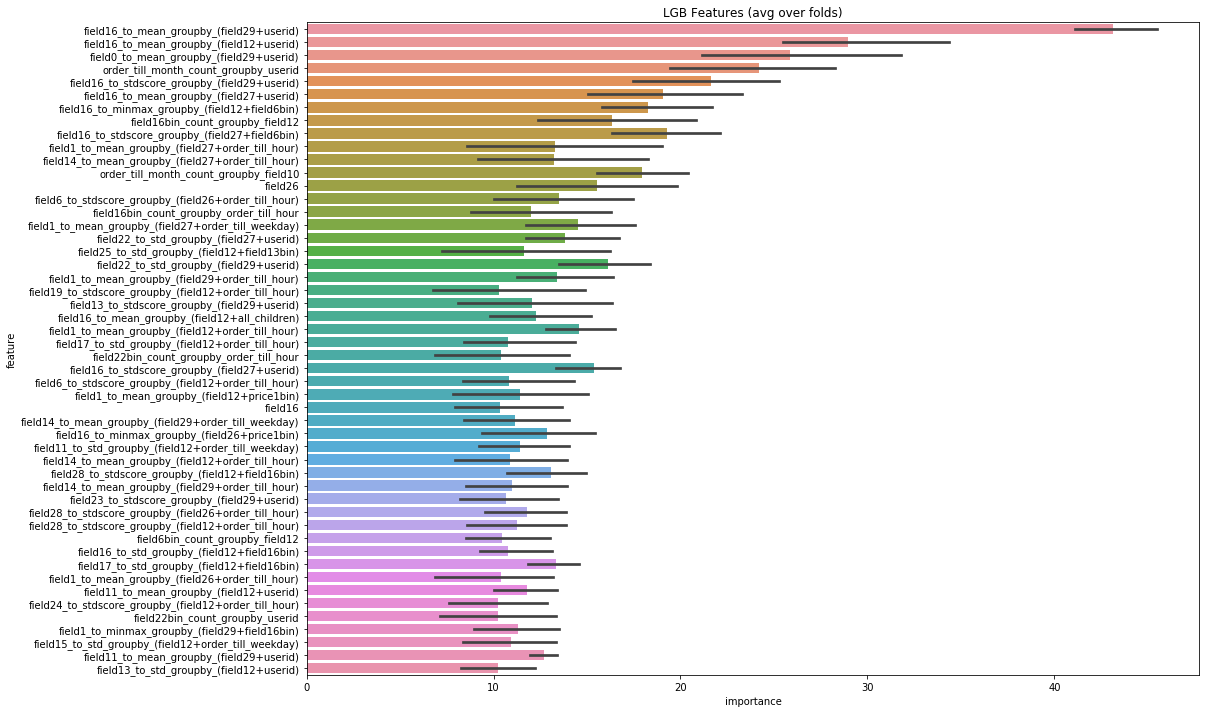

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Sat Jan  4 00:16:16 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.746556	training's auc: 0.746542	valid_1's auc: 0.662057	valid_1's auc: 0.661889
[200]	training's auc: 0.782639	training's auc: 0.782646	valid_1's auc: 0.670029	valid_1's auc: 0.67003
[300]	training's auc: 0.815747	training's auc: 0.815747	valid_1's auc: 0.675619	valid_1's auc: 0.675618
[400]	training's auc: 0.844988	training's auc: 0.844989	valid_1's auc: 0.676379	valid_1's auc: 0.676379
[500]	training's auc: 0.866748	training's auc: 0.866748	valid_1's auc: 0.678385	valid_1's auc: 0.678385
[600]	training's auc: 0.885753	training's auc: 0.885753	valid_1's auc: 0.678988	valid_1's auc: 0.678988
[700]	training's auc: 0.903013	training's auc: 0.903013	valid_1's auc: 0.679358	valid_1's auc: 0.679358
[800]	training's auc: 0.916768	training's auc: 0.916768	valid_1's auc: 0.679804	valid_1's auc: 0.679804
[900]	training's auc: 0.928922	training's auc: 0.928922	valid_1

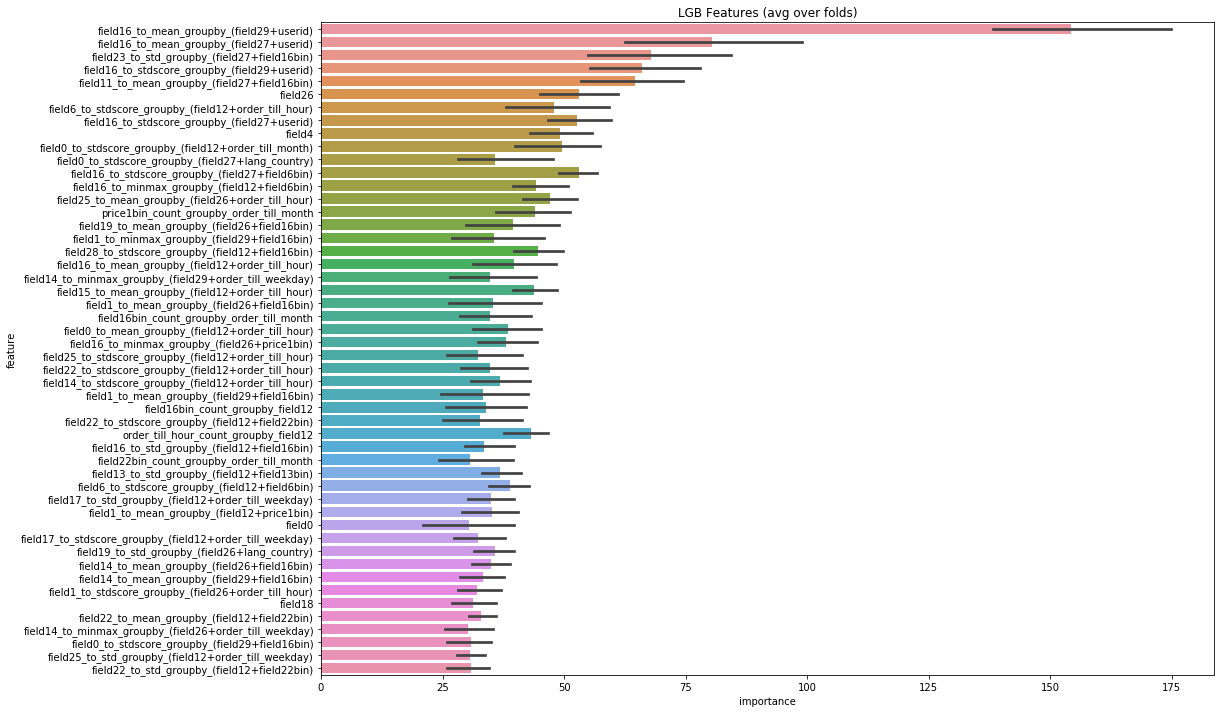

In [18]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan  3 21:08:48 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.730488	training's auc: 0.730467	valid_1's auc: 0.659146	valid_1's auc: 0.65916
[200]	training's auc: 0.767492	training's auc: 0.767488	valid_1's auc: 0.66742	valid_1's auc: 0.667414
[300]	training's auc: 0.796697	training's auc: 0.796698	valid_1's auc: 0.672982	valid_1's auc: 0.672978
[400]	training's auc: 0.823394	training's auc: 0.823394	valid_1's auc: 0.675598	valid_1's auc: 0.675597
[500]	training's auc: 0.845877	training's auc: 0.845877	valid_1's auc: 0.675653	valid_1's auc: 0.675653
Early stopping, best iteration is:
[414]	training's auc: 0.826622	training's auc: 0.826623	valid_1's auc: 0.675732	valid_1's auc: 0.675732
Fold 2 started at Fri Jan  3 21:10:31 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.730909	training's auc: 0.73095	valid_1's auc: 0.704397	valid_1's auc: 0.704421
[200]	training's auc: 0.7679

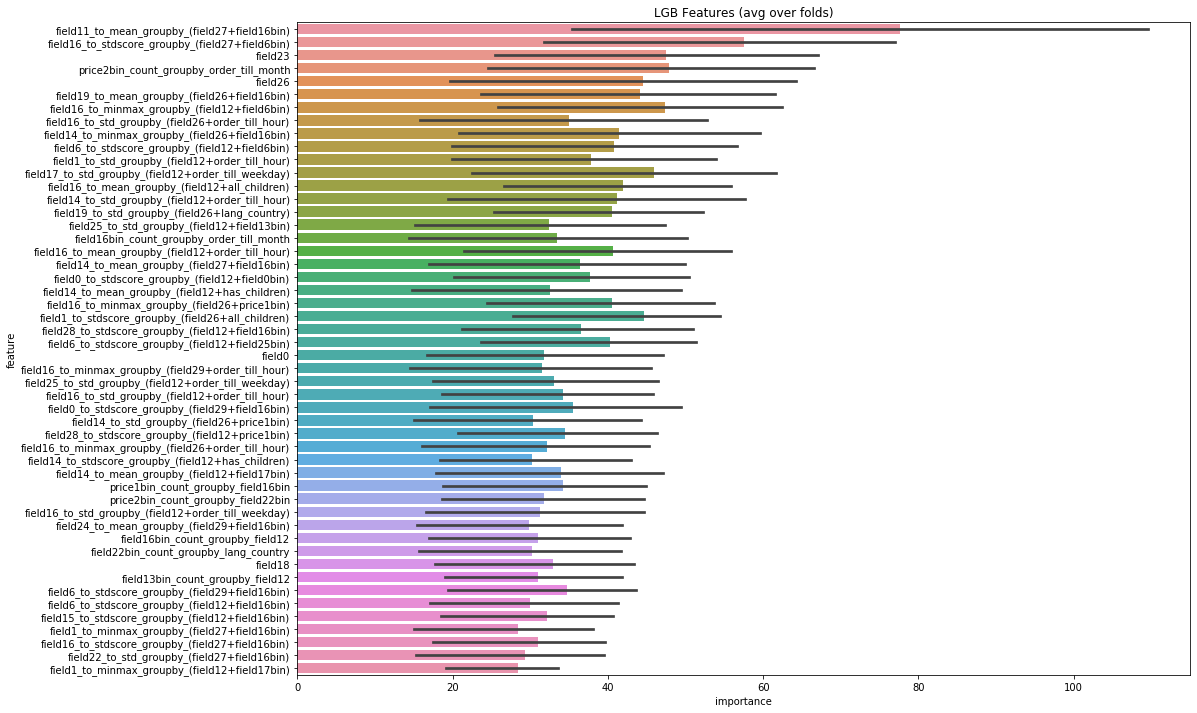

In [33]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Jan  3 20:11:47 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.714071	training's auc: 0.714056	valid_1's auc: 0.653947	valid_1's auc: 0.654007
Early stopping, best iteration is:
[26]	training's auc: 0.691099	training's auc: 0.69106	valid_1's auc: 0.657657	valid_1's auc: 0.657594
Fold 2 started at Fri Jan  3 20:11:57 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.701145	training's auc: 0.701186	valid_1's auc: 0.708607	valid_1's auc: 0.708571
[200]	training's auc: 0.720136	training's auc: 0.720142	valid_1's auc: 0.710664	valid_1's auc: 0.710638
[300]	training's auc: 0.743753	training's auc: 0.743748	valid_1's auc: 0.711764	valid_1's auc: 0.711751
[400]	training's auc: 0.76013	training's auc: 0.760129	valid_1's auc: 0.711556	valid_1's auc: 0.711552
[500]	training's auc: 0.777258	training's auc: 0.777259	valid_1's auc: 0.71371	valid_1's auc: 0.713709
Did not meet early stopping. 

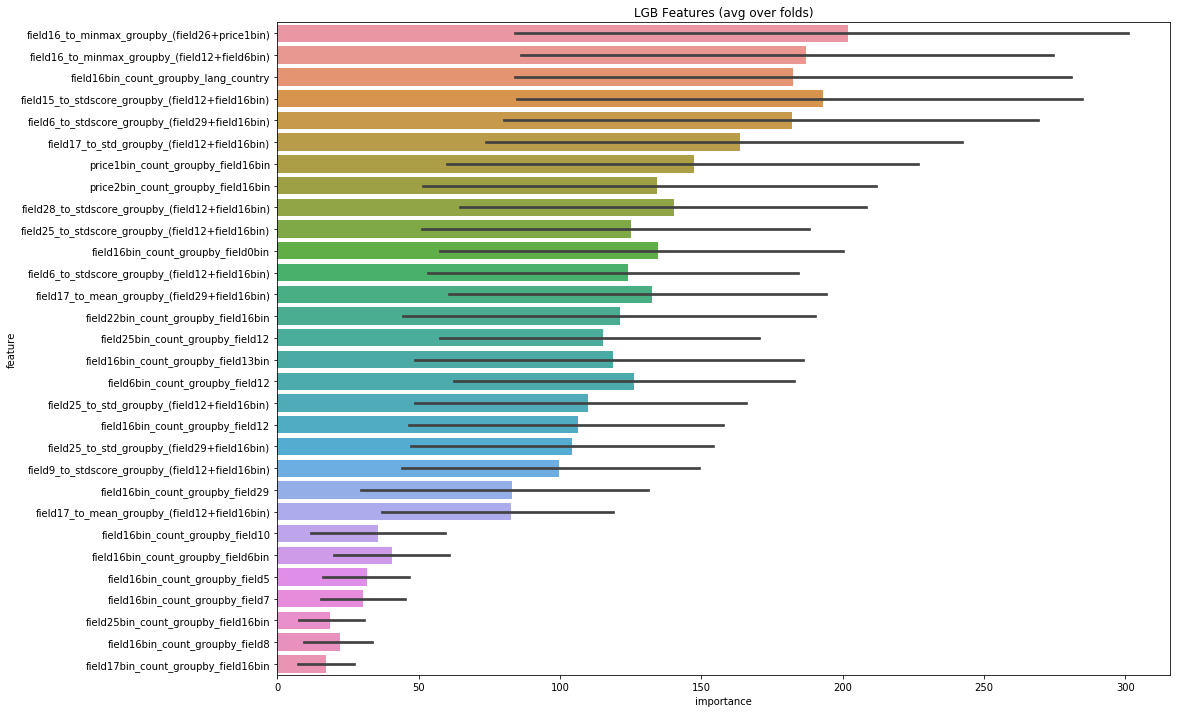

In [17]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

Fold 1 started at Fri Dec 20 08:09:14 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783373	training's auc: 0.783376	valid_1's auc: 0.672257	valid_1's auc: 0.672271
[200]	training's auc: 0.838349	training's auc: 0.83835	valid_1's auc: 0.681522	valid_1's auc: 0.681522
[300]	training's auc: 0.877625	training's auc: 0.877625	valid_1's auc: 0.68447	valid_1's auc: 0.68447
[400]	training's auc: 0.901645	training's auc: 0.901645	valid_1's auc: 0.684089	valid_1's auc: 0.684089
Early stopping, best iteration is:
[322]	training's auc: 0.884313	training's auc: 0.884313	valid_1's auc: 0.684702	valid_1's auc: 0.684702
Fold 2 started at Fri Dec 20 08:14:27 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.77402	training's auc: 0.774022	valid_1's auc: 0.718327	valid_1's auc: 0.718332
[200]	training's auc: 0.834075	training's auc: 0.834075	valid_1's auc: 0.726482	valid_1's auc: 0.726481
[300]	training's auc: 0.87351

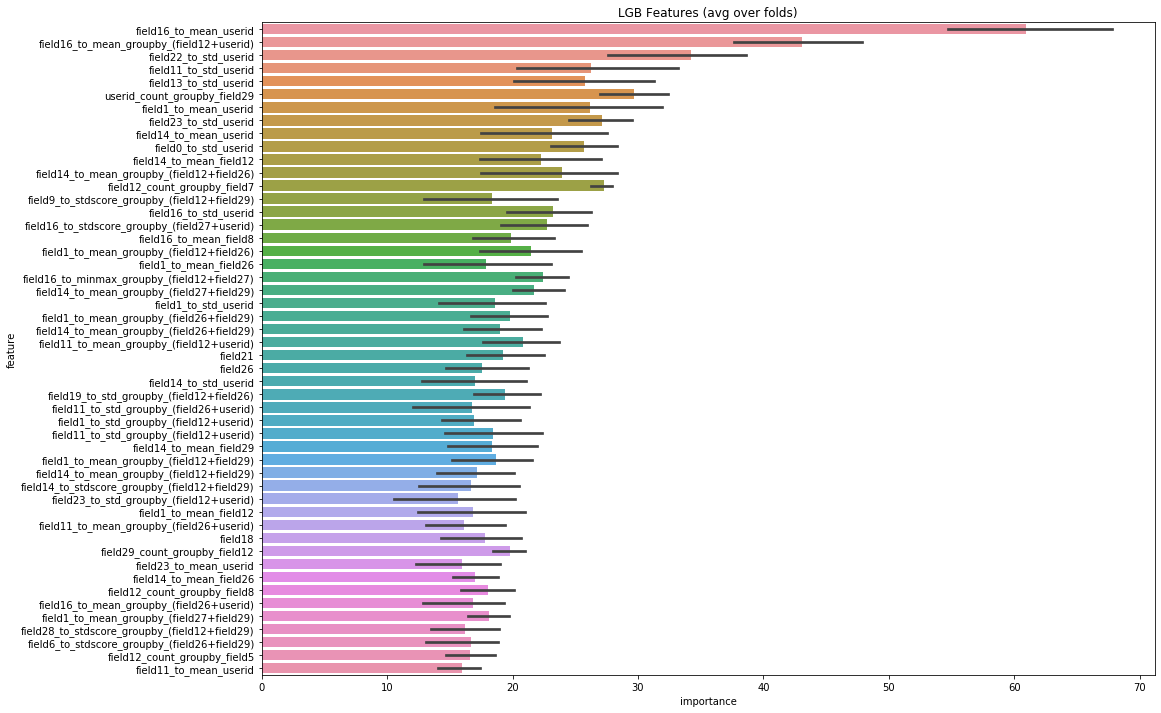

In [72]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [21]:
result_dict = result_dict_cb

In [22]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'temp/submission-{t}.csv')

## Goal2

In [19]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1','userid',]

In [21]:
sub2 = pd.read_csv('data/onetwotrip_challenge_sub2.csv')

In [40]:
sub2.columns = ['orderid', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']
sub2 = pd.DataFrame(0, columns=sub2.columns, index=sub2.index)

Goal  1
Fold 1 started at Tue Dec 17 16:18:17 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.875224	training's auc: 0.875224	valid_1's auc: 0.701886	valid_1's auc: 0.701886
[200]	training's auc: 0.925883	training's auc: 0.925883	valid_1's auc: 0.696779	valid_1's auc: 0.696779
Early stopping, best iteration is:
[100]	training's auc: 0.875224	training's auc: 0.875224	valid_1's auc: 0.701886	valid_1's auc: 0.701886
Fold 2 started at Tue Dec 17 16:19:23 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.876093	training's auc: 0.876093	valid_1's auc: 0.693512	valid_1's auc: 0.693512
Early stopping, best iteration is:
[30]	training's auc: 0.792081	training's auc: 0.792081	valid_1's auc: 0.700029	valid_1's auc: 0.700029
Fold 3 started at Tue Dec 17 16:20:16 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.879044	training's auc: 0.879044	valid_1's auc: 0.704456	valid_1'

Early stopping, best iteration is:
[20]	training's auc: 0.941855	training's auc: 0.941858	valid_1's auc: 0.906676	valid_1's auc: 0.906645
Fold 4 started at Tue Dec 17 16:38:07 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.981925	training's auc: 0.981925	valid_1's auc: 0.894457	valid_1's auc: 0.894457
[200]	training's auc: 0.993774	training's auc: 0.993774	valid_1's auc: 0.893544	valid_1's auc: 0.893544
Early stopping, best iteration is:
[113]	training's auc: 0.984797	training's auc: 0.984797	valid_1's auc: 0.894875	valid_1's auc: 0.894875
Fold 5 started at Tue Dec 17 16:38:56 2019
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.982665	training's auc: 0.982665	valid_1's auc: 0.897471	valid_1's auc: 0.897471
Early stopping, best iteration is:
[58]	training's auc: 0.969519	training's auc: 0.969519	valid_1's auc: 0.898072	valid_1's auc: 0.898072
CV mean score: 0.9016, std: 0.0060.


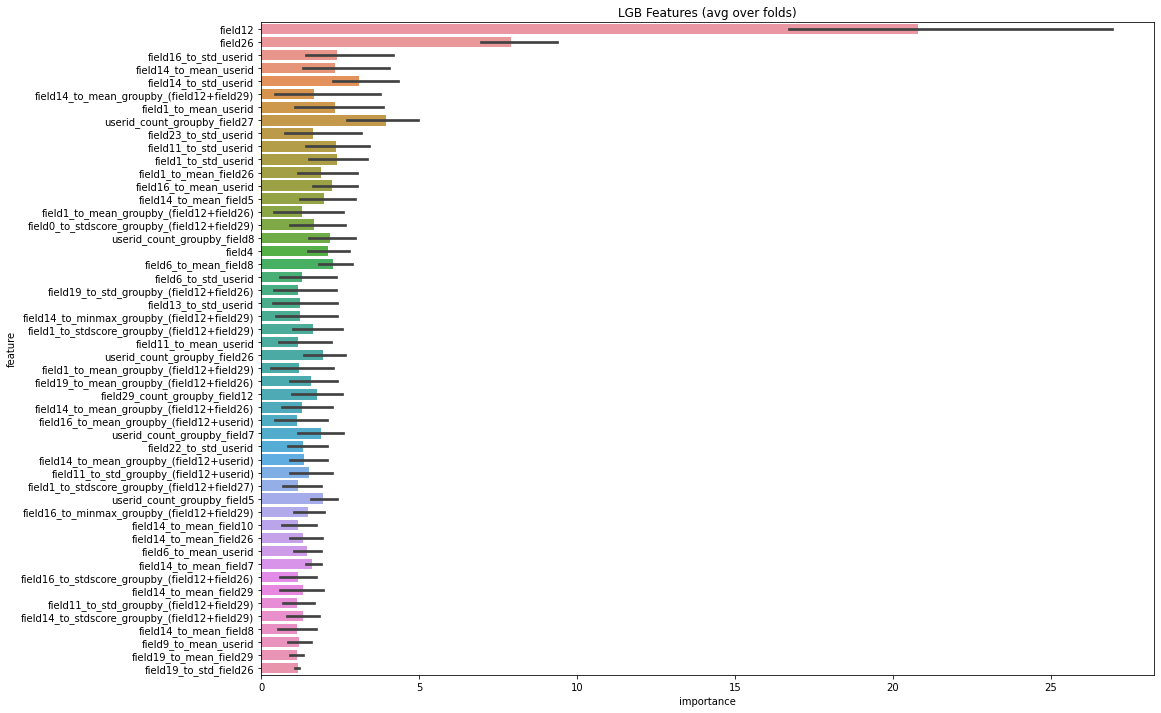

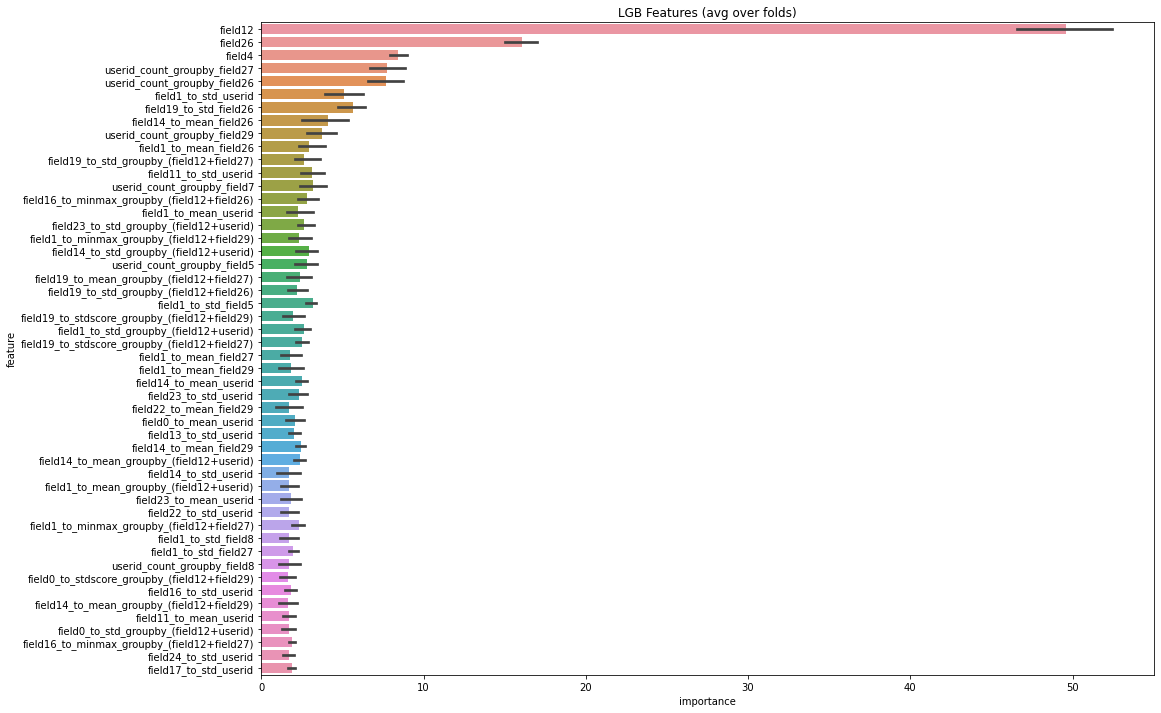

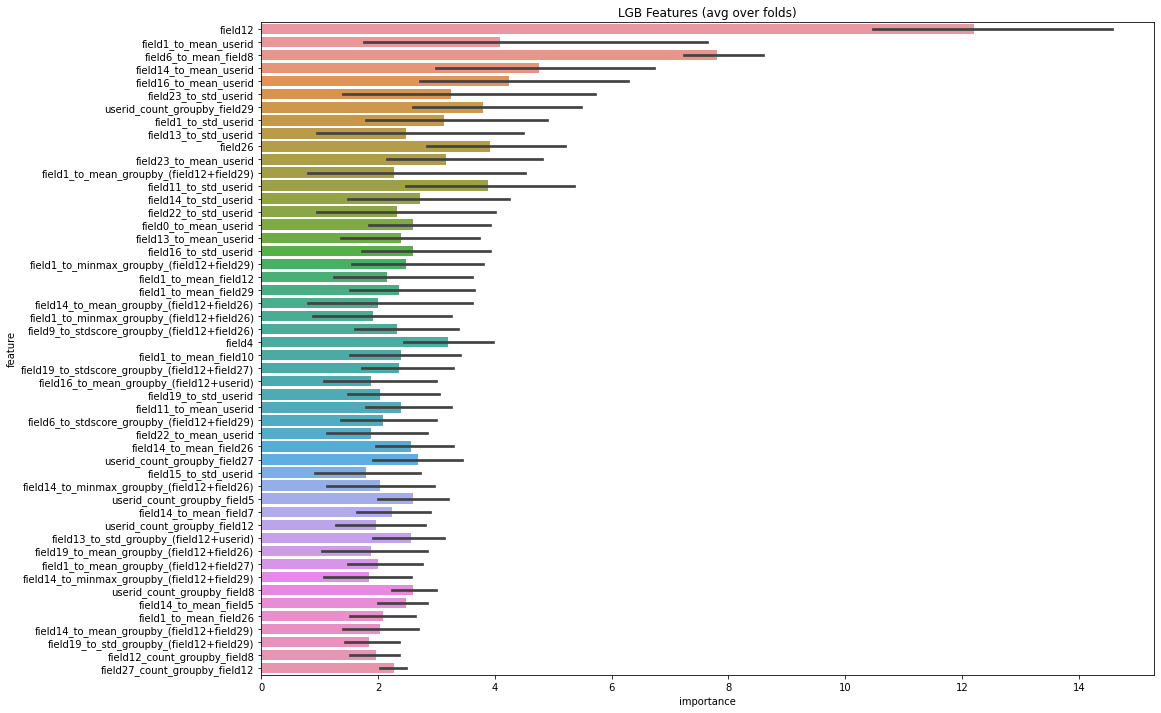

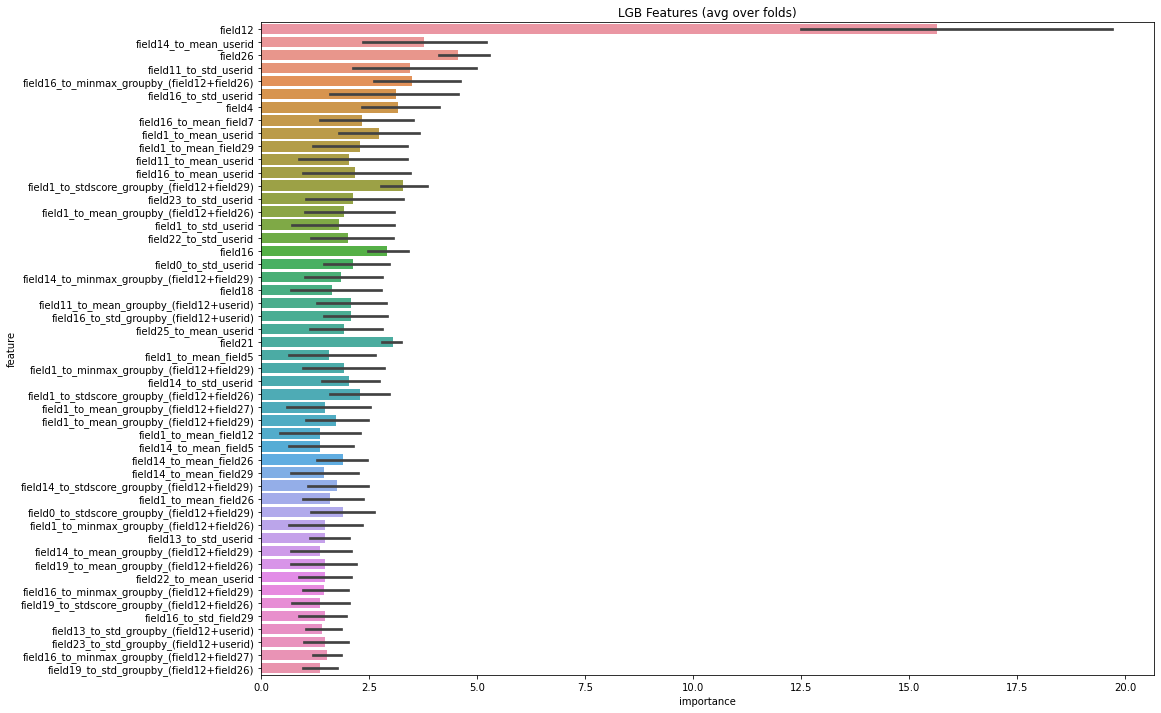

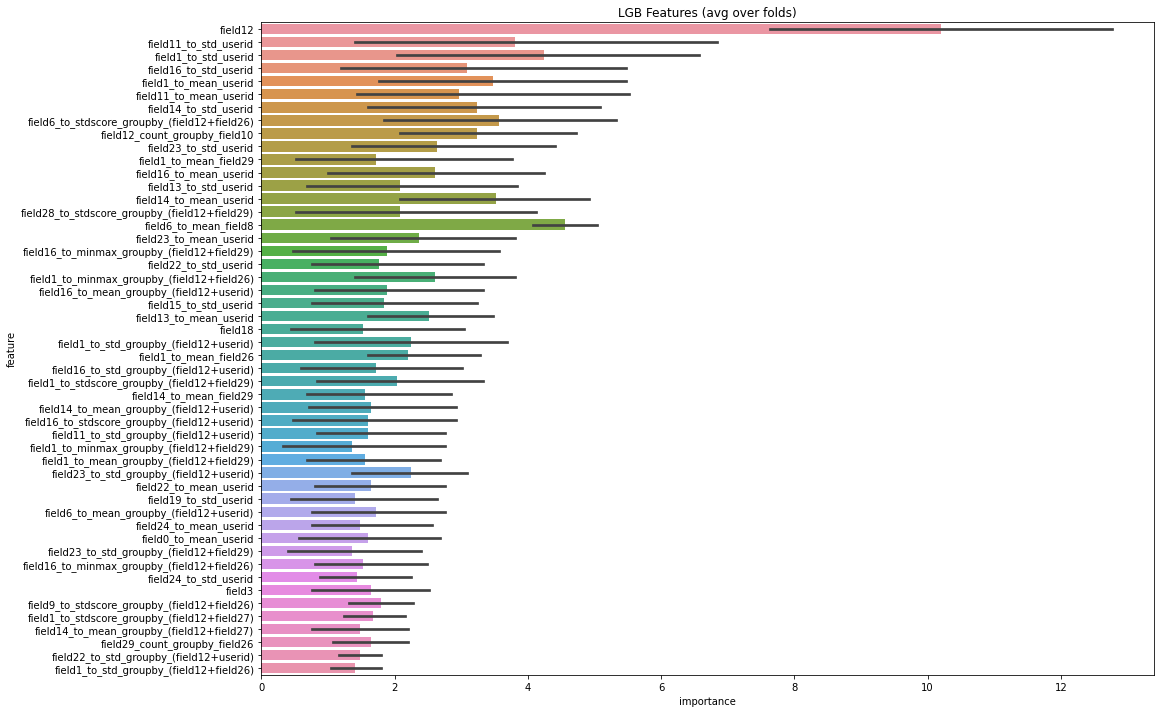

In [41]:
from sklearn.model_selection import GroupKFold, KFold

data = p.data['data']
for i_goal in range(1,6):
    print ("Goal ", i_goal)
    data_filtered = data[data[f'indicator_goal2{i_goal}'] == 1]
    X = data_filtered[data_filtered[f'goal2{i_goal}']>=0].drop([f'goal2{i_goal}'], axis=1)
    y = data_filtered[data_filtered[f'goal2{i_goal}']>=0][f'goal2{i_goal}']
    test=data[data[f'goal2{i_goal}']<0]
    train_features = [f for f in data.columns if f not in exclude_features_from_training]


    NFOLDS = 5
    folds = GroupKFold(n_splits=NFOLDS)
    params = {
              'objective': 'binary',
              "metric": 'auc',
              "verbosity": -1,
             }
    train_options = {
            "model_type":'lgb',
            "params": params,
            "eval_metric":'auc',
            'early_stopping_rounds': 100,
            'n_estimators': 500,
            'averaging': 'rank',
            'use_groups': False,
            'fold_name': folds.__class__.__name__,
            'n_splits': NFOLDS
        }

    result_dict = train_model_classification_vb( X=X, 
                                                 X_test=test, 
                                                 columns=train_features,
                                                 y=y, 
                                                 params=params, folds=folds,
                                                 model_type=train_options['model_type'], 
                                                 plot_feature_importance=True,
                                                 verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                 n_estimators=train_options['n_estimators'], 
                                                 averaging=train_options['averaging'],
                                                 groups=X['userid'],
                                                 n_jobs=-1)
    test[f'proba2{i_goal}'] = result_dict['prediction']
    sub2[f'goal2{i_goal}'] = test[f'proba2{i_goal}'] / test[f'proba2{i_goal}'].max()
    
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.reset_index(drop=True).to_csv(f'{p.working_folder}/submission2-{t}.csv')

In [44]:
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
sub2.drop(['orderid'],axis=1).reset_index(drop=True).to_csv(f'{p.working_folder}/submission2-{t}.csv')

## Results

### NO FE. initial

Fold 1 started at Sun Dec 15 19:17:47 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.8352	training's auc: 0.8352	valid_1's auc: 0.660413	valid_1's auc: 0.660413
Early stopping, best iteration is:
[36]	training's auc: 0.769533	training's auc: 0.769533	valid_1's auc: 0.671052	valid_1's auc: 0.671052
Fold 2 started at Sun Dec 15 19:17:58 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.832962	training's auc: 0.832962	valid_1's auc: 0.708005	valid_1's auc: 0.708005
Early stopping, best iteration is:
[27]	training's auc: 0.742707	training's auc: 0.742708	valid_1's auc: 0.71381	valid_1's auc: 0.713811
Fold 3 started at Sun Dec 15 19:18:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833846	training's auc: 0.833846	valid_1's auc: 0.684287	valid_1's auc: 0.684287
Early stopping, best iteration is:
[28]	training's auc: 0.753781	training's auc: 0.753782	valid_1's

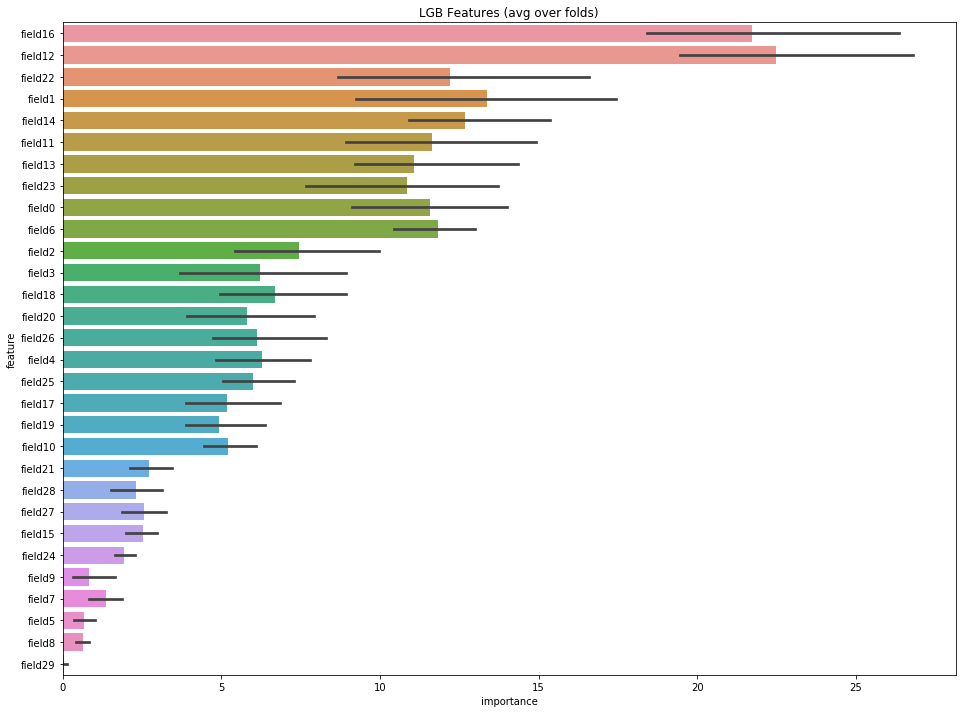

In [22]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### add first aggregate node

Fold 1 started at Sun Dec 15 20:21:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.892444	training's auc: 0.892444	valid_1's auc: 0.672213	valid_1's auc: 0.672213
Early stopping, best iteration is:
[67]	training's auc: 0.857729	training's auc: 0.857729	valid_1's auc: 0.676682	valid_1's auc: 0.676682
Fold 2 started at Sun Dec 15 20:21:38 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890783	training's auc: 0.890783	valid_1's auc: 0.705956	valid_1's auc: 0.705956
Early stopping, best iteration is:
[40]	training's auc: 0.817173	training's auc: 0.817173	valid_1's auc: 0.72028	valid_1's auc: 0.720279
Fold 3 started at Sun Dec 15 20:22:05 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.890927	training's auc: 0.890927	valid_1's auc: 0.688385	valid_1's auc: 0.688385
Early stopping, best iteration is:
[33]	training's auc: 0.803194	training's auc: 0.803194	valid

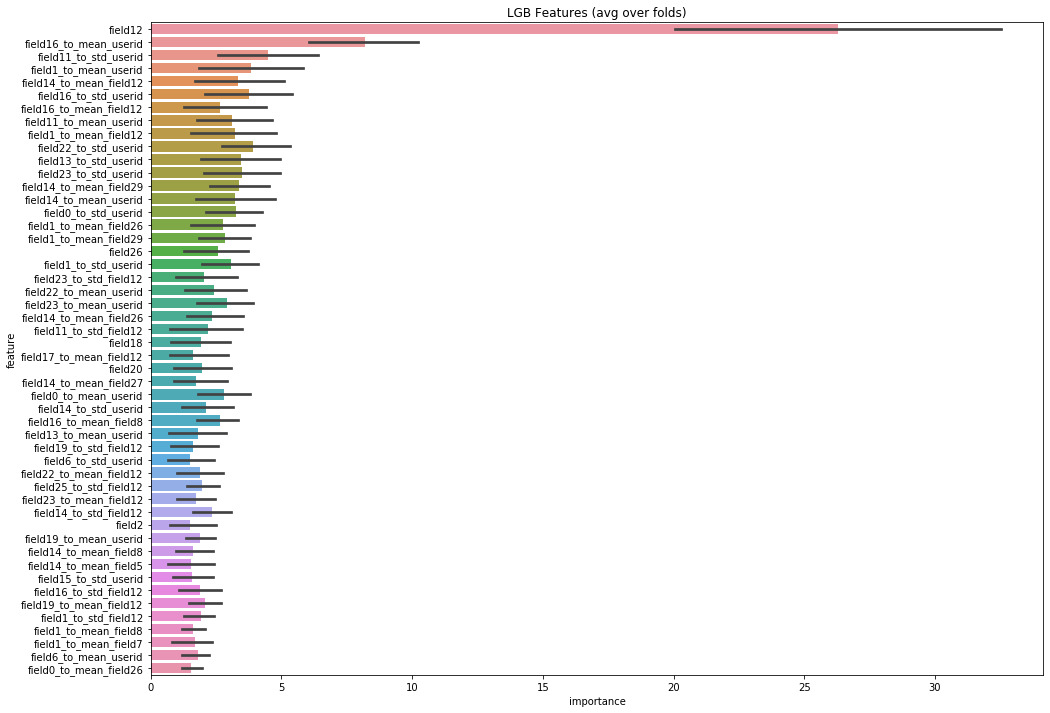

In [13]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### More aggregates

Fold 1 started at Mon Dec 16 23:23:56 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904606	training's auc: 0.904606	valid_1's auc: 0.671887	valid_1's auc: 0.671887
Early stopping, best iteration is:
[50]	training's auc: 0.847829	training's auc: 0.847829	valid_1's auc: 0.676644	valid_1's auc: 0.676644
Fold 2 started at Mon Dec 16 23:24:55 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900505	training's auc: 0.900505	valid_1's auc: 0.712615	valid_1's auc: 0.712615
Early stopping, best iteration is:
[34]	training's auc: 0.810291	training's auc: 0.810291	valid_1's auc: 0.718987	valid_1's auc: 0.718985
Fold 3 started at Mon Dec 16 23:25:42 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.900145	training's auc: 0.900145	valid_1's auc: 0.694774	valid_1's auc: 0.694774
Early stopping, best iteration is:
[46]	training's auc: 0.84242	training's auc: 0.84242	valid_

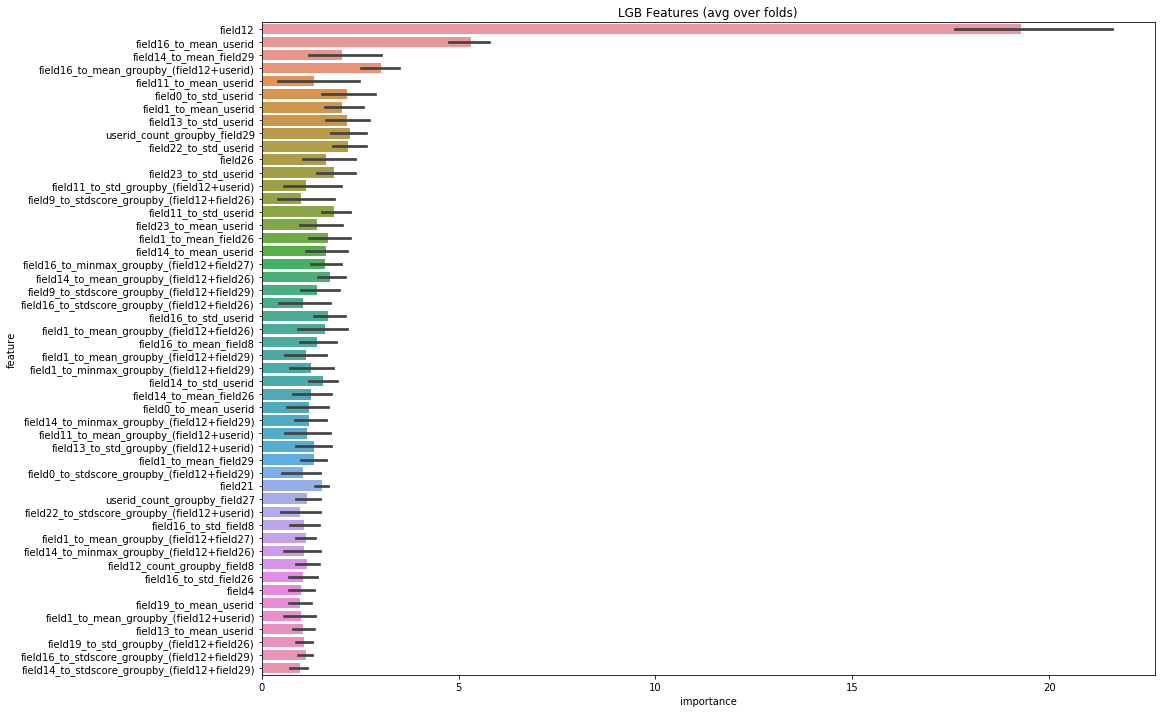

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

### Aggs+rfe+tune params (0.6847) - submission_rfe-12-19-20-54.csv

Fold 1 started at Wed Dec 18 21:29:43 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.784354	training's auc: 0.784353	valid_1's auc: 0.671344	valid_1's auc: 0.671339
[200]	training's auc: 0.828908	training's auc: 0.828908	valid_1's auc: 0.676033	valid_1's auc: 0.676032
[300]	training's auc: 0.866599	training's auc: 0.866599	valid_1's auc: 0.678715	valid_1's auc: 0.678715
[400]	training's auc: 0.894881	training's auc: 0.894881	valid_1's auc: 0.679986	valid_1's auc: 0.679986
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.91094	training's auc: 0.91094	valid_1's auc: 0.67955	valid_1's auc: 0.67955
Fold 2 started at Wed Dec 18 21:32:46 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.771693	training's auc: 0.771689	valid_1's auc: 0.712078	valid_1's auc: 0.71208
[200]	training's auc:

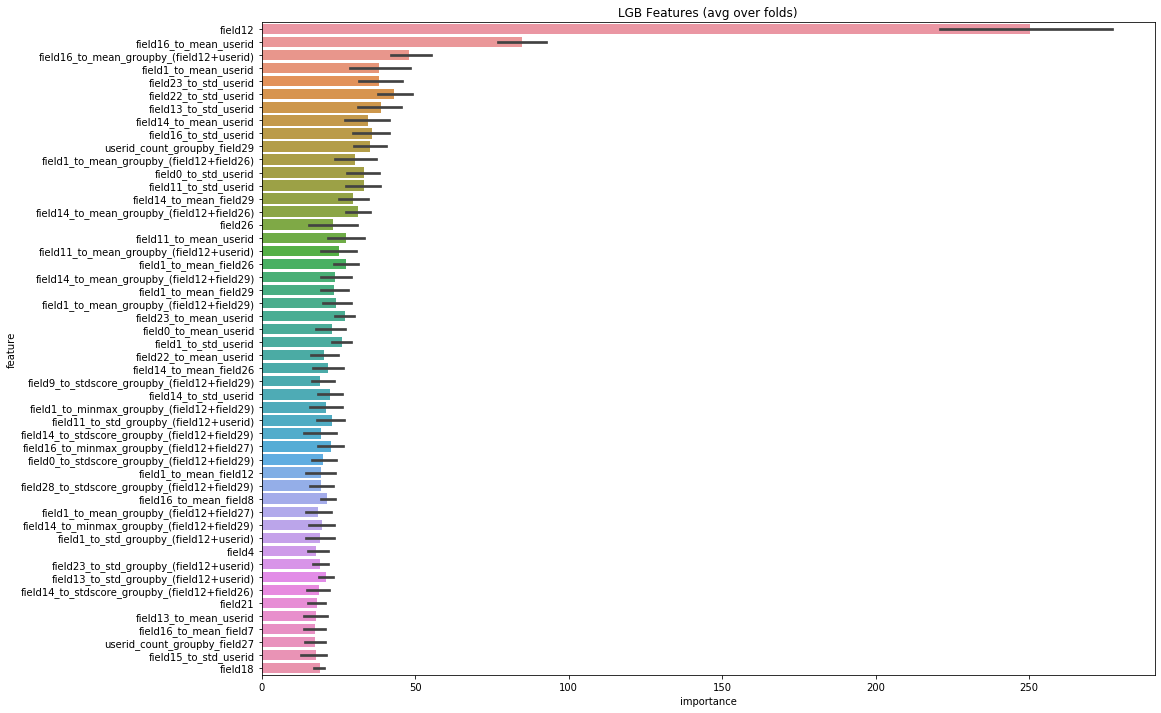

In [19]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)